<a href="https://colab.research.google.com/github/AdityaSingirikonda19/weatherapp/blob/main/Copy_of_Final_Plotted_WildfireSpreadPredictionCNNLTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fantineh/next-day-wildfire-spread

100% 2.07G/2.08G [00:19<00:00, 87.4MB/s]
100% 2.08G/2.08G [00:19<00:00, 115MB/s] 


In [ ]:
!unzip /content/next-day-wildfire-spread.zip

Archive:  /content/next-day-wildfire-spread.zip
  inflating: next_day_wildfire_spread_eval_00.tfrecord  
  inflating: next_day_wildfire_spread_eval_01.tfrecord  
  inflating: next_day_wildfire_spread_test_00.tfrecord  
  inflating: next_day_wildfire_spread_test_01.tfrecord  
  inflating: next_day_wildfire_spread_train_00.tfrecord  
  inflating: next_day_wildfire_spread_train_01.tfrecord  
  inflating: next_day_wildfire_spread_train_02.tfrecord  
  inflating: next_day_wildfire_spread_train_03.tfrecord  
  inflating: next_day_wildfire_spread_train_04.tfrecord  
  inflating: next_day_wildfire_spread_train_05.tfrecord  
  inflating: next_day_wildfire_spread_train_06.tfrecord  
  inflating: next_day_wildfire_spread_train_07.tfrecord  
  inflating: next_day_wildfire_spread_train_08.tfrecord  
  inflating: next_day_wildfire_spread_train_09.tfrecord  
  inflating: next_day_wildfire_spread_train_10.tfrecord  
  inflating: next_day_wildfire_spread_train_11.tfrecord  
  inflating: next_day_wildfi

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

In [ ]:
train_file_pattern = '/content/next_day_wildfire_spread_train*'
val_file_pattern = '/content/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/next_day_wildfire_spread_test*'

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

DATA_STATS = {'elevation': (0.0, 3141.0, 657.3003, 649.0147), 'pdsi': (-6.1298, 7.8760, -0.0053, 2.6823), 'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677), 'pr': (0.0, 44.5304, 1.7398051, 4.4828), 'sph': (0., 1., 0.0071658953, 0.0042835088), 'th': (0., 360.0, 190.3298, 72.5985), 'tmmn': (253.15, 298.9489, 281.08768, 8.9824), 'tmmx': (253.15, 315.0923, 295.17383, 9.8155), 'vs': (0.0, 10.0243, 3.8501, 1.4110), 'erc': (0.0, 106.2489, 37.3263, 20.8460), 'population': (0., 2534.0630, 25.5314, 154.7233), 'PrevFireMask': (-1., 1., 0., 1.), 'FireMask': (-1., 1., 0., 1.)}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox


In [ ]:
def input_output_images(input_img:tf.Tensor, output_img:tf.Tensor, sample_size:int, num_in_channels:int, num_out_channels:int):
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(combined,[sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img
  #return combined
#input_output_images(input_img, output_img, sample_size, num_in_channels, 1)


In [ ]:

def random_crop_input_and_output_images(input_img:tf.Tensor, output_img:tf.Tensor, sample_size:int, num_in_channels:int, num_out_channels:int,) -> Tuple[tf.Tensor, tf.Tensor]:
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(input_img: tf.Tensor, output_img: tf.Tensor, sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [ ]:

def _get_base_key(key: Text) -> Text:
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError(
      f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(example_proto: tf.train.Example, data_size: int, sample_size: int, num_in_channels: int, clip_and_normalize: bool, clip_and_rescale: bool, random_crop: bool, center_crop: bool,) -> Tuple[tf.Tensor, tf.Tensor]:
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [_clip_and_normalize(features.get(key), key) for key in input_features]
  elif clip_and_rescale:
    inputs_list = [_clip_and_rescale(features.get(key), key) for key in input_features]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3''but dimensions of outputs_stacked'f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int, batch_size: int, num_in_channels: int, compression_type: Text, clip_and_normalize: bool, clip_and_rescale: bool, random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(lambda x: _parse_fn(x, data_size, sample_size, num_in_channels, clip_and_normalize, clip_and_rescale, random_crop, center_crop),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = get_dataset(
  train_file_pattern,
  data_size=64,
  sample_size=32,
  batch_size=100,
  num_in_channels=12,
  compression_type=None,
  clip_and_normalize=False,
  clip_and_rescale=False,
  random_crop=True,
  center_crop=False
)
val_dataset = get_dataset(
    val_file_pattern,
    data_size=64,
    sample_size=32,
    batch_size=100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)
test_dataset = get_dataset(
    test_file_pattern,
    data_size=64,
    sample_size=32,
    batch_size=100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)

In [ ]:
from timeit import default_timer as timer
class TimingCallback(keras.callbacks.Callback):
  def __init__(self, logs={}):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs={}):
    self.starttime = timer()
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(timer()-self.starttime)
tcb = TimingCallback()

In [ ]:
# Define some callbacks to improve training.
checkpoint = ModelCheckpoint("model.hdf5", monitor = 'val_auc', verbose = 1, save_best_only = False, period = 1)

def algo_train():
  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

  # Define modifiable training hyperparameters.
  epochs = 20
  batch_size = 100

  # Fit the model to the training data.
  history = model.fit(
      features_np,
      firemask_np,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(features_val_np,firemask_val_np),
      callbacks=[early_stopping, reduce_lr, tcb, checkpoint]
  )
  return history

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(1, 32, 32, 12))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=[tf.keras.metrics.AUC()]
)


In [ ]:
weights_auc = []
weights_loss = []

def add_weights(history, sum_auc, sum_loss):
  weights = history.history
  result = weights.items()
  data = list(result)
  data_np = np.array(data)
  for x in range(len(data_np[0][1])):
    sum_auc = sum_auc + data_np[1][1][x]
    sum_loss = sum_loss + data_np[0][1][x]
  weights_auc.append(sum_auc/len(data_np[0][1]))
  weights_loss.append(sum_loss/len(data_np[0][1]))

In [ ]:
global sum_auc, sum_loss
sum_auc = 0
sum_loss = 0
train_iter = iter(train_dataset)
val_iter = iter(val_dataset)
for i in range(150):
  # features, firemask = next(iter(train_dataset))
  features, firemask = next(train_iter)
  features_np = features.numpy()
  firemask_np = firemask.numpy()
  features_np = np.expand_dims(features_np, axis = 1)
  firemask_np = np.expand_dims(firemask_np, axis = 1)
  # features_val, firemask_val = next(iter(val_dataset))
  features_val, firemask_val = next(val_iter)
  features_val_np = features_val.numpy()
  firemask_val_np = firemask_val.numpy()
  features_val_np = np.expand_dims(features_val_np, axis = 1)
  firemask_val_np = np.expand_dims(firemask_val_np, axis = 1)
  history = algo_train()
  #model.save('drive.google.com/drive/folders/1jcYiH6yeu9H2TRSQXC5SdHJX2B5pMFoS?usp=sharing')
  print("ITERATION: ", i+1)
  add_weights(history, sum_auc, sum_loss)


Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6612 - auc: 0.4824
Epoch 1: saving model to model.hdf5
1/1 [==============================] - 24s 24s/step - loss: 0.6612 - auc: 0.4824 - val_loss: 0.6064 - val_auc: 0.4945 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6356 - auc: 0.4978
Epoch 2: saving model to model.hdf5
1/1 [==============================] - 0s 187ms/step - loss: 0.6356 - auc: 0.4978 - val_loss: 0.6007 - val_auc: 0.4926 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.6122 - auc: 0.5327
Epoch 3: saving model to model.hdf5
1/1 [==============================] - 0s 181ms/step - loss: 0.6122 - auc: 0.5327 - val_loss: 0.5915 - val_auc: 0.4728 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.5858 - auc: 0.5138
Epoch 4: saving model to model.hdf5
1/1 [==============================] - 0s 218ms/step - loss: 0.5858 - auc: 0.5138 - val_loss: 0.6007 - val_auc: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  



Epoch 1: saving model to model.hdf5
1/1 [==============================] - 0s 242ms/step - loss: 0.2601 - auc: 0.4508 - val_loss: 0.3439 - val_auc: 0.4858 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.2400 - auc: 0.4605
Epoch 2: saving model to model.hdf5
1/1 [==============================] - 0s 181ms/step - loss: 0.2400 - auc: 0.4605 - val_loss: 0.3335 - val_auc: 0.4835 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.2214 - auc: 0.4793
Epoch 3: saving model to model.hdf5
1/1 [==============================] - 0s 182ms/step - loss: 0.2214 - auc: 0.4793 - val_loss: 0.3276 - val_auc: 0.4806 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.2060 - auc: 0.5170
Epoch 4: saving model to model.hdf5
1/1 [==============================] - 0s 179ms/step - loss: 0.2060 - auc: 0.5170 - val_loss: 0.3254 - val_auc: 0.4809 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 

StopIteration: ignored

In [ ]:
weights_auc


[0.4663668304681778,
 0.5673468943153109,
 0.6525323987007141,
 0.546140393614769,
 0.6130216836929321,
 0.48166857808828356,
 0.632901331782341,
 0.6183793097734451,
 0.4983106508851051,
 0.6223599195480347,
 0.6471446481618014,
 0.6432891815900803,
 0.6674133658409118,
 0.6394557535648346,
 0.6017045825719833,
 0.6698615550994873,
 0.598990085721016,
 0.5446710735559464,
 0.615840744972229]

In [ ]:
weights_loss

[0.42415574565529823,
 0.16843287593552045,
 0.13976898789405823,
 -0.012101088743656873,
 0.11508187726140022,
 0.04275694638490677,
 0.14564943984150885,
 0.12539171278476716,
 0.0410992618650198,
 0.14881013557314873,
 0.009295571510764685,
 0.18616237938404084,
 0.16022233814001083,
 0.13974886015057564,
 0.17531270831823348,
 0.1857982494614341,
 0.07033324539661408,
 -0.1333935834467411,
 0.182026257365942]

ValueError: ignored

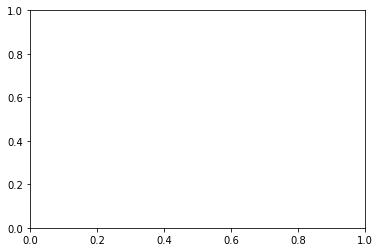

In [ ]:
iteration_arr = []

for i in range(150):
  iteration_arr.append(i+1)

plt.plot(iteration_arr, weights_auc)

plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.title("AUC Plot")

plt.show()


ValueError: ignored

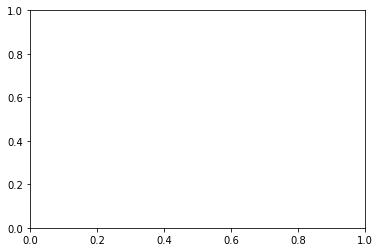

In [ ]:
plt.plot(iteration_arr, weights_loss, 'r')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

In [ ]:
print(f"Average time per epoch: {sum(tcb.logs)/len(tcb.logs)} seconds")
print(f"Total Time taken: {sum(tcb.logs)}")

Average time per epoch: 0.21367127079539142 seconds
Total Time taken: 74.14393096600082


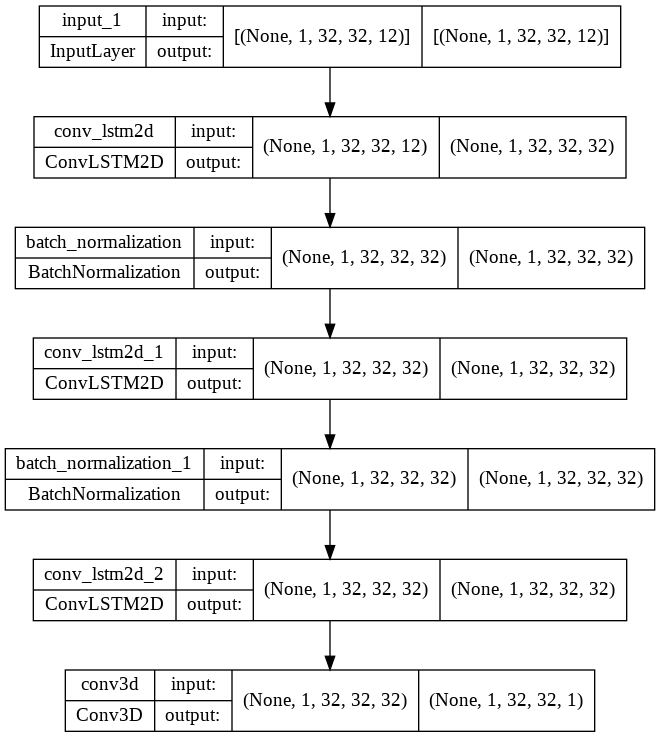

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
#model = Sequential()
#model.add(Dense(2, input_dim=1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir = 'TB', expand_nested = True)


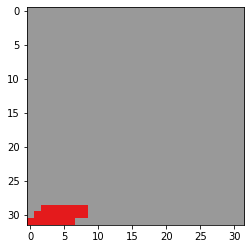

In [ ]:
a = firemask_np[9][0].reshape(32,32)
plt.imshow(a, cmap="Set1_r")